In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from attention import Attention
from keras import losses

In [2]:
text_df = pd.read_csv("../dataset/text_embedding.csv")

audio_df = pd.read_csv("../dataset/audio_embedding.csv")
audio_df.head()
text_df.head()


,0,0.1,1,2,3,4,5,6,7,8,...,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607
0,5,5.354230,3.535457,7.348618,4.718048,7.335632,6.937083,3.644210,4.429690,4.881655,...,1.99443,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
1,2,6.343656,3.772492,6.890505,6.539682,6.515871,3.221131,2.128765,3.987325,1.806336,...,1.99443,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
2,4,8.652696,4.187095,3.165394,2.999270,6.707338,1.457551,0.000000,4.810442,1.611260,...,1.99443,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
3,5,3.549071,6.404244,7.015340,4.225493,4.072373,5.748169,6.250419,7.483934,4.623145,...,1.99443,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0
4,5,2.842956,3.263400,7.103064,4.562712,6.050471,7.587608,3.260895,6.198865,4.598395,...,1.99443,0.817898,1.219209,4.230605,1.940278,0.0,2.618883,4.770179,0.067875,0.0


1-disgust,angry,sad; 2-fear; 3-neutral; 4-happy; 5-surprise

In [3]:
#Processing audio sentiments data, divided into five levels, corresponding to text
temp_df = audio_df
temp_df = temp_df.replace("m_disgust", 1)
temp_df = temp_df.replace("f_disgust", 1)
temp_df = temp_df.replace("m_angry", 1)
temp_df = temp_df.replace("f_angry", 1)
temp_df = temp_df.replace("m_sad", 1)
temp_df = temp_df.replace("f_sad", 1)


temp_df = temp_df.replace("m_fear", 2)
temp_df = temp_df.replace("f_fear", 2)

temp_df = temp_df.replace("m_neutral", 3)
temp_df = temp_df.replace("f_neutral", 3)

temp_df = temp_df.replace("m_happy", 4)
temp_df = temp_df.replace("f_happy", 4)

temp_df = temp_df.replace("m_surprise", 5)
temp_df = temp_df.replace("f_surprise", 5)
temp_df.head()


,0,0.1,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,3,-0.504281,-0.427365,-0.519557,-0.629859,-0.629859,-0.519913,-0.629859,-0.556203,-0.605106,...,-0.430297,-0.399582,-0.075815,-0.135701,-0.004715,-0.189843,0.161181,-0.371715,-0.199839,-0.186286
1,1,-0.110983,-0.103890,-0.063182,-0.114516,-0.112650,-0.172134,-0.225444,-0.192116,-0.175435,...,-0.163251,0.155345,-0.007225,0.039680,-0.186692,0.047228,0.170926,0.070092,0.553698,0.011350
2,3,-0.101387,-0.146695,-0.127515,-0.158159,-0.172775,-0.212269,-0.242705,-0.179039,-0.182775,...,0.667429,0.881873,0.712925,0.744448,0.596081,0.673980,0.845208,0.876801,0.844952,0.439054
3,2,-0.155329,-0.124418,-0.243442,-0.107044,-0.413908,-0.117588,-0.001165,-0.186451,-0.499862,...,0.200291,0.068006,0.034221,0.183618,0.210933,0.145808,-0.020882,-0.095218,-0.226382,-0.253818
4,3,-0.392306,-0.315623,-0.441369,-0.353499,-0.290997,-0.454479,-0.442850,-0.479907,-0.629859,...,0.247008,0.219731,0.275426,0.211315,0.314326,0.270123,0.117642,0.074828,-0.188160,-0.292886


In [4]:
#1. To process the sound data into labels, first use the mean method, but also can use the random matching method
label_1_df = temp_df[temp_df['0']==1].drop(['0'], axis=1)
label_2_df = temp_df[temp_df['0']==2].drop(['0'], axis=1)
label_3_df = temp_df[temp_df['0']==3].drop(['0'], axis=1)
label_4_df = temp_df[temp_df['0']==4].drop(['0'], axis=1)
label_5_df = temp_df[temp_df['0']==5].drop(['0'], axis=1)
label_5_df.head()

,0.1,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
6,0.107176,0.005858,-0.165378,-0.042031,-0.016324,-0.118086,-0.090499,-0.191589,-0.182541,0.426354,...,0.049141,0.055161,-0.197144,-0.324759,-0.248146,-0.331781,-0.405820,-0.436498,-0.466729,-0.434224
12,-0.069141,-0.012695,-0.038202,0.163442,-0.193723,-0.178407,0.279102,0.360952,-0.101620,-0.028517,...,0.321243,0.097413,0.020248,-0.024512,-0.096788,-0.258461,-0.264746,-0.384613,-0.225357,-0.305030
25,0.191594,1.120439,0.464091,1.038317,0.415505,0.247260,-0.113227,-0.161013,0.011642,0.071186,...,-0.341070,-0.365121,-0.394818,-0.095435,-0.629859,-0.582577,-0.264739,-0.629859,-0.629859,-0.565380
27,0.070384,0.187052,-0.250209,-0.308157,-0.144561,0.208861,-0.257057,-0.491679,-0.010079,0.404974,...,-0.629859,-0.368926,-0.477797,-0.372338,-0.374255,-0.338099,-0.304441,-0.263491,-0.179632,-0.233453
28,-0.527099,-0.629859,-0.221839,0.111992,-0.248225,-0.158702,-0.505763,-0.629859,-0.492404,-0.074787,...,0.180881,0.023598,-0.467709,-0.579216,-0.296176,-0.414056,-0.432907,-0.364209,-0.274338,-0.238519


In [5]:
label_1_mean_arr = np.array(label_1_df.mean(axis=0))
label_2_mean_arr = np.array(label_2_df.mean(axis=0))
label_3_mean_arr = np.array(label_3_df.mean(axis=0))
label_4_mean_arr = np.array(label_4_df.mean(axis=0))
label_5_mean_arr = np.array(label_5_df.mean(axis=0))
label_5_mean_arr.shape

(108,)

In [6]:
text_df.index

RangeIndex(start=0, stop=8603, step=1)

In [7]:
label_temp_df = pd.DataFrame()
for index in text_df.index:
    if text_df['0'].get(index) == 1:
        label_temp_df.insert(loc=len(label_temp_df.columns), \
            column = len(label_temp_df.columns),value=label_1_mean_arr)
    elif text_df['0'].get(index) == 2:
        label_temp_df.insert(loc=len(label_temp_df.columns), 
        column = len(label_temp_df.columns),value=label_2_mean_arr)
    elif text_df['0'].get(index) == 3:
        label_temp_df.insert(loc=len(label_temp_df.columns), \
            column = len(label_temp_df.columns),value=label_3_mean_arr)
    elif text_df['0'].get(index) == 4:
        label_temp_df.insert(loc=len(label_temp_df.columns), \
            column = len(label_temp_df.columns),value=label_4_mean_arr)
    else:
        label_temp_df.insert(loc=len(label_temp_df.columns), \
            column = len(label_temp_df.columns),value=label_5_mean_arr)

/home/ubuntu/miniconda3/envs/audio1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
label_temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8593,8594,8595,8596,8597,8598,8599,8600,8601,8602
0,-0.019869,0.018819,-0.006503,-0.019869,-0.019869,0.018819,-0.159859,0.018819,0.018819,-0.159859,...,-0.006503,-0.006503,0.018819,-0.019869,-0.054535,0.018819,-0.054535,0.018819,-0.019869,0.018819
1,0.018758,0.068565,0.017683,0.018758,0.018758,0.068565,-0.159620,0.068565,0.068565,-0.159620,...,0.017683,0.017683,0.068565,0.018758,-0.021704,0.068565,-0.021704,0.068565,0.018758,0.068565
2,0.017629,0.089554,-0.001863,0.017629,0.017629,0.089554,-0.186045,0.089554,0.089554,-0.186045,...,-0.001863,-0.001863,0.089554,0.017629,-0.025155,0.089554,-0.025155,0.089554,0.017629,0.089554
3,0.009359,0.113345,0.011532,0.009359,0.009359,0.113345,-0.198795,0.113345,0.113345,-0.198795,...,0.011532,0.011532,0.113345,0.009359,-0.032260,0.113345,-0.032260,0.113345,0.009359,0.113345
4,-0.048684,0.044502,-0.033004,-0.048684,-0.048684,0.044502,-0.202923,0.044502,0.044502,-0.202923,...,-0.033004,-0.033004,0.044502,-0.048684,-0.063656,0.044502,-0.063656,0.044502,-0.048684,0.044502


In [9]:
label_temp_df=pd.DataFrame(label_temp_df.values.T,index=label_temp_df.columns,columns=label_temp_df.index)   #转置
label_Y = np.array(label_temp_df)
label_Y.shape

(8603, 108)

In [10]:
text_tmep_df = text_df
text_X = text_tmep_df.drop(['0'], axis=1)
text_X = np.array(text_X)
text_X.shape

(8603, 1608)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split( text_X, label_Y, test_size=0.25, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6452, 1608)
(6452, 108)
(2151, 1608)
(2151, 108)


In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print(X_train.shape)
print(Y_train.shape)


(6452, 1608, 1)
(6452, 108, 1)


In [48]:
# Define/compile the model.
model_input = Input(shape=(1608, 1))
x = Dense(108)(model_input)
x = Attention(units=64)(x)
x = Dense(108)(x)
model = Model(model_input, x)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1608, 1)]         0         
                                                                 
 dense_27 (Dense)            (None, 1608, 108)         216       
                                                                 
 attention_9 (Attention)     (None, 64)                25488     
                                                                 
 dense_28 (Dense)            (None, 108)               7020      
                                                                 
Total params: 32,724
Trainable params: 32,724
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Cosine Loss
import tensorflow as tf
#high efficiency
def getAcc(predict, label):
    return -tf.losses.cosine_similarity(predict, label)

In [40]:
batch_size = 16
epochs = 50

In [41]:
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]

In [43]:
# train.
model.compile(loss="mse", optimizer="adam", metrics=[getAcc])
model_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                batch_size = 32, verbose = 1, epochs=5, callbacks=callbacks)

Epoch 1/5
202/202 [==============================] - 163s 804ms/step - loss: 0.0112 - getAcc: 0.9131 - val_loss: 0.0108 - val_getAcc: 0.9165 - lr: 0.0010
Epoch 2/5
202/202 [==============================] - 170s 844ms/step - loss: 0.0110 - getAcc: 0.9141 - val_loss: 0.0106 - val_getAcc: 0.9168 - lr: 0.0010
Epoch 3/5
202/202 [==============================] - 173s 858ms/step - loss: 0.0109 - getAcc: 0.9145 - val_loss: 0.0110 - val_getAcc: 0.9160 - lr: 0.0010
Epoch 4/5
202/202 [==============================] - 175s 868ms/step - loss: 0.0110 - getAcc: 0.9142 - val_loss: 0.0107 - val_getAcc: 0.9171 - lr: 0.0010
Epoch 5/5
202/202 [==============================] - 175s 868ms/step - loss: 0.0108 - getAcc: 0.9147 - val_loss: 0.0107 - val_getAcc: 0.9168 - lr: 0.0010


In [44]:
import matplotlib.pyplot as plt

def create_plot(model_history):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def create_plot_acc(model_history):
    plt.plot(model_history.history['getAcc'])
    plt.plot(model_history.history['val_getAcc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

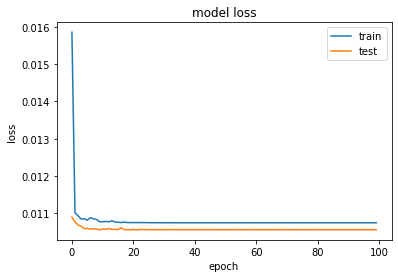

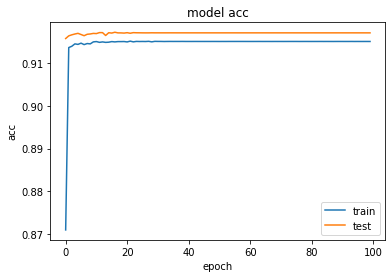

In [45]:
create_plot(model_history)
create_plot_acc(model_history)

In [44]:
# test save/reload model.
pred1 = model.predict(X_test)
print(pred1.shape)
print(Y_test.shape)

(2151, 108)
(2151, 108)


In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def getCosAcc1(predict, label):
    acc = 0
    sum = 0
    for i in range(predict.shape[0]):
        sum += cosine_similarity(predict[i].reshape(1, -1), label[i].reshape(1, -1))
    acc = sum / predict.shape[0]
    return acc

In [46]:
getCosAcc1(pred1, Y_test)

array([[0.91682955]])

In [47]:
# test save/reload model.
pred1 = model.predict(X_test)
model.save('mapping_model.h5')
model_h5 = load_model('mapping_model.h5', custom_objects={'Attention': Attention, 'getAcc':getAcc})
pred2 = model_h5.predict(X_test)
np.testing.assert_almost_equal(pred1, pred2)

In [49]:
model_h5 = load_model('mapping_model.h5', custom_objects={'Attention': Attention, 'getAcc':getAcc})
pred1 = model_h5.predict(X_train)
pred2 = model_h5.predict(X_test)

In [50]:
label_set = np.vstack([label_1_mean_arr.reshape(1, 108), label_2_mean_arr.reshape(1, 108),
label_3_mean_arr.reshape(1, 108), label_4_mean_arr.reshape(1, 108), label_5_mean_arr.reshape(1, 108)])
label_set.shape

(5, 108)

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
results = []
for i in range(5): 
    results.append(cosine_similarity(pred1[1].reshape(1, -1), label_set[i].reshape(1, -1))[0][0])
results

[0.9613804637810579,
 0.922156943458926,
 0.7243342266264883,
 0.9909960223659974,
 0.9705123989747125]

In [58]:
#MSE
results = []
for i in range(5):
    results.append(np.mean((pred1[1].reshape(1, -1) - label_set[i].reshape(1, -1)) ** 2))
results

[0.004470112268874556,
 0.010288745159185604,
 0.029082795936701804,
 0.005262473047269254,
 0.003986450522770615]

In [ ]:

AEs = {}#Dictionary of Audio Embedding we extracted from the dataset, the
# key to the dictionary is the roots of the corresponding audio file, and
# the value is the corresponding audio Embedding.

pred = None
#Predicted Audio Embedding

#We implement similarity calculation between pred and AEs.

from sklearn.metrics.pairwise import cosine_similarity
results = {}
for key, value in AEs:
    results[key] = cosine_similarity(pred.reshape(1, -1), value.reshape(1, -1))
    #MSE: results[key] = np.mean((pred1[1].reshape(1, -1) - label_set[i].reshape(1, -1)) ** 2)

sortedList = sorted(results.items, key=lambda kv:(kv(1), kv[0]), reverse=True)
#Reverse sorting based on dictionary values.

sortedList[0][0]
#The first element of the first tuple in the list is the path of the sound file.